# Equazione del calore

### Soluzione esatta equazione del calore

In [ ]:
def aheat(u,v,du,dv,xL=0,dx=1):
    return lambda x: du(x)*dv(x)

def heatkernel(x,t,k):
    # funzione di green dell'equazione del calore, k diffusività
    return x*0 if t==0 else np.exp(-x**2/(4*k*t))/np.sqrt(4*np.pi*k*t)

def heatexact(x,t,k,g,grigliaconv):
    # soluzione esatta equazione del calore con integrazione gaussiana
    y = x*0
    for i in tqdm(range(len(x))):
        xvar = x[i]
        y[i] = grigliaconv.integrate(lambda y: g(y)*heatkernel(xvar-y,t,k))
    return y
    
def heatexactconv(x,t,k,g):
    # soluzione esatta equazione del calore con convoluzione di scipy
    kernel = heatkernel(x-(b-a)/2,t,k)
    G = g(X)
    return convolve(G,kernel,mode="same")/sum(kernel)

### Test su equazione del calore
La miglior condizione iniziale è quella $C^2$ a supporto compatto per velocizzare il calcolo della soluzione esatta (collo di bottiglia).

100%|██████████| 101/101 [00:00<00:00, 641.26it/s]


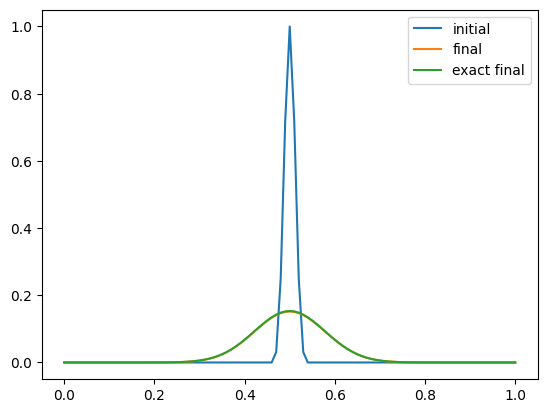

In [ ]:
ndof = 4
a, b = 0, 1
fe = FE(ndof)
griglia = GRID(a,b,25,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,aheat,constantdiffusion=True)

p = fe.Pol
dt = 0.00001
t = 0
eps = (b-a)/50
Nsteps = 300

# f0 = lambda x: np.exp(-(x-(a+b)/2)**2/eps**2)
# f0 = lambda x: gauss(x,(b-a)*0.4,eps)+ gauss(x, (b-a)*0.6,eps) 
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
# f0 = lambda x: waterbag(x,(a+b)/2,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
ax.plot(X,u,label="initial")
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
ax.plot(X,u,label="final")
k=1

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,5)
Y = heatexact(X,t,k,f0,grigliaconv)
ax.plot(X,Y,label="exact final")

if t==0:
    t=1
# Yc = heatexactconv(X,t,k,f0)
# ax.plot(X,Yc,label="convolve final")
ax.legend()

plt.show()

## Test convergenza su equazione del calore

### Convergenza spaziale

In [ ]:
a, b = 0, 1
dt = 2**1*1e-6
T = 2**12*1e-6
Nsteps = int(T/dt)

figfolder = "graphics/convergenza_spaziale"
Path(figfolder).mkdir(parents=True,exist_ok=True)

Ns = 5*np.logspace(1,2,10).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50*2
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,50)

ndofs = np.arange(1,5)
fe = FE(ndof)

k = 1

errs_ndofs = []
counter = 0
for ndof in ndofs:
    fe = FE(ndof)
    errs = []

    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,aheat,constantdiffusion=True)
        
        t = 0

        X = griglia.globV
        u = f0(X)
        ts = []
        fig, ax = plt.subplots()
        ax.plot(X,u,label="initial")
        for i in range(Nsteps):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt*(b-a),griglia.M,A)
        
        Y = heatexact(X,t,k,f0,grigliaconv)
        err = np.sqrt(np.sum((u-Y)**2))
        errs.append(err)
        ax.plot(X,u,label="final")
        ax.plot(X,Y,label="exact final")
        ax.set_title(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

    errs = np.array(errs)
    errs_ndofs.append(errs)

with open("h.pkl","wb") as f:
    pickle.dump(errs,f)

  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 2001/2001 [00:41<00:00, 48.67it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'h.pickle'

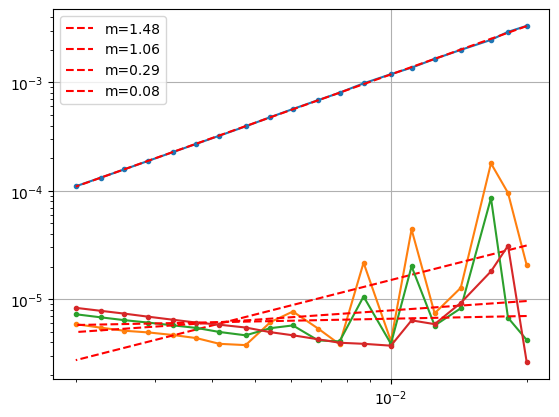

In [ ]:
with open("h.pkl","rb") as f:
    errs = pickle.load(f)

fig, ax = plt.subplots()

for errs in errs_ndofs:
    Xfit = np.log10(hs)
    Yfit = np.log10(errs)
    popt, _ = curve_fit(line,Xfit,Yfit)
    ax.plot(hs,errs,'.-')
    ax.plot(hs,10**line(Xfit,*popt),'--r',label=f"m={popt[0]:0.2f}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

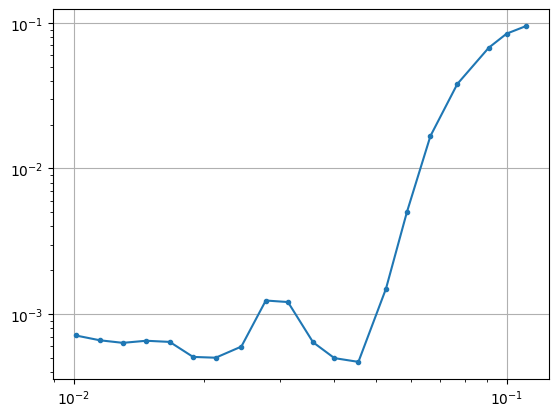

In [ ]:
fig, ax = plt.subplots()
Xfit = np.log10(hs)
Yfit = np.log10(errs)
# popt, _ = curve_fit(line,Xfit,Yfit)
ax.plot(hs,errs,'.-C0')
# ax.plot(hs,10**line(hs,*popt),'--C1')
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
plt.show()